In [0]:
!pip install optuna

In [0]:
!unzip titanic.zip

In [0]:
from keras import layers
from keras import Input
from keras.models import Model
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import optuna
import seaborn as sns

'''
サンプルの生成
'''
train = pd.read_csv("train.csv")      # (891, 12)
test = pd.read_csv("test.csv")        # (418, 11)

full_data = [train, test]

train_len = len(train)      # 891
test_len = len(test)        # 418

# train.head()
# print(test.head())
# print(test.shape)
# print(train.shape)
# train.describe()
# print(test.describe())


In [0]:
'''
データの前処理
'''
def normalization(x):        # 正規化
    x -= np.mean(x)
    x /= np.std(x)
    return x

def missing_table(df):      # データの欠損を計算
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    missing_table_ren_columns = missing_table.rename(
        columns = {0:"欠損数", 1:"%"}
    )
    return missing_table_ren_columns

# missing_table(train)
# print(missing_table(test))

for i in range(len(train)):
  train["Name"][i] = train["Name"][i].split('.')[0].split(', ')[1]
for i in range(len(test)):
  test["Name"][i] = test["Name"][i].split('.')[0].split(', ')[1]

  
# 欠損の穴埋め
train["Cabin"] = train["Cabin"].fillna(0)
train["Age"] = train["Age"].fillna(train["Age"].median())
train["Embarked"] = train["Embarked"].fillna("S")
train["Sex"][train["Sex"]=="male"] = 0
train["Sex"][train["Sex"]=="female"] = 1
train["Embarked"][train["Embarked"]=="S"] = 0
train["Embarked"][train["Embarked"]=="C"] = 1
train["Embarked"][train["Embarked"]=="Q"] = 2

test["Cabin"] = test["Cabin"].fillna(0)
test["Age"] = test["Age"].fillna(test["Age"].median())
test["Sex"][test["Sex"]=="male"] = 0
test["Sex"][test["Sex"]=="female"] = 1
test["Embarked"][test["Embarked"]=="S"] = 0
test["Embarked"][test["Embarked"]=="C"] = 1
test["Embarked"][test["Embarked"]=="Q"] = 2
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

train["Sex"] = pd.to_numeric(train["Sex"], errors='coerce')
train["Embarked"] = pd.to_numeric(train["Embarked"], errors='coerce')
test["Sex"] = pd.to_numeric(test["Sex"], errors='coerce')
test["Embarked"] = pd.to_numeric(test["Embarked"], errors='coerce')

In [0]:
for dataset in full_data:
    dataset.loc[ dataset['Cabin'] != 0, 'Cabin'] = 1
    
#     dataset.loc[ dataset['Name'] == 'Mr', 'Name'] = 1
#     dataset.loc[ dataset['Name'] == 'Miss', 'Name'] = 2
#     dataset.loc[ dataset['Name'] == 'Mrs', 'Name'] = 3
#     dataset.loc[ dataset['Name'] == 'Master', 'Name'] = 4
#     dataset.loc[(dataset['Name'] != 'Mr') & (dataset['Name'] != 'Miss') & (dataset['Name'] != 'Mrs') & (dataset['Name'] != 'Master'), 'Name'] = 0
    dataset['Name'] =  dataset['Name'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4})
  
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [0]:
train['Name'] = train['Name'].fillna(0)
test['Name'] = test['Name'].fillna(0)

In [0]:
# 一人かどうか
alone_train = np.zeros((train_len))
for i in range(train_len):
    if train["Parch"][i].all()==0 and train["SibSp"][i].all()==0:
        alone_train[i] = 1
alone_test = np.zeros((test_len))
for i in range(test_len):
    if test["Parch"][i].all()==0 and test["SibSp"][i].all()==0:
        alone_test[i] = 1

list_alone_train = list(alone_train.astype(int))
pd_alone_train = pd.DataFrame({'Alone':alone_train})
train = pd.concat([train.reset_index(drop=True), pd_alone_train.reset_index(drop=True)], axis=1)
list_alone_test = list(alone_test.astype(int))
pd_alone_test = pd.DataFrame({'Alone':alone_test})
test = pd.concat([test.reset_index(drop=True), pd_alone_test.reset_index(drop=True)], axis=1)

In [0]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corrmat, vmax=.8, annot = True, center = 0)

In [0]:
n_train = 891
val_ratio = 0.3
f_name = 'model_titanic_trained.h5'
# f_name = 'model_titanic_tset.h5'

In [0]:
'''
入力の生成
'''
train_dropped = train.drop(['PassengerId', 'Ticket'], axis=1)
train_x = train_dropped.drop('Survived', axis=1)
train_y = train_dropped.Survived

In [0]:
# 各要素の配列
Pclass_list = np.zeros((train_len, 3))
Name_list = np.zeros((train_len, 5))
Sex_list = np.zeros((train_len, 2))
Age_list = np.zeros((train_len, 5))
SibSp_list = np.zeros((train_len, 10))
Parch_list = np.zeros((train_len, 10))
Fare_list = np.zeros((train_len, 4))
Embarked_list = np.zeros((train_len, 3))
Cabin_list = np.zeros((train_len, 2))
Alone_list = np.zeros((train_len))
Survived_list = np.zeros((train_len))

for i in range(train_len):
    Pclass_list[i, train["Pclass"][i]-1] = 1
    Name_list[i, train["Name"][i].astype(int)] = 1
    Sex_list[i, train["Sex"][i]] = 1
    Age_list[i, train["Age"][i].astype(int)] = 1
    SibSp_list[i, train["SibSp"][i].astype(int)] = 1
    Parch_list[i, train["Parch"][i].astype(int)] = 1
    Fare_list[i, train["Fare"][i].astype(int)] = 1
    Embarked_list[i, train["Embarked"][i]] = 1
    Cabin_list[i, train["Cabin"][i]] = 1
    Alone_list[i] = train["Alone"][i]
    Survived_list[i] = train["Survived"][i]
    


# 正規化
# Age_list = normalization(Age_list)
# SibSp_list = normalization(SibSp_list)
# Parch_list = normalization(Parch_list)
# Fare_list = normalization(Fare_list)


train_Pclass_list = Pclass_list[:n_train]
train_Name_list = Name_list[:n_train]
train_Sex_list = Sex_list[:n_train]
train_Age_list = Age_list[:n_train]
train_SibSp_list = SibSp_list[:n_train]
train_Parch_list = Parch_list[:n_train]
train_Fare_list = Fare_list[:n_train]
train_Embarked_list = Embarked_list[:n_train]
train_Cabin_list = Cabin_list[:n_train]
train_Alone_list = Alone_list[:n_train]
train_Survived_list = Survived_list[:n_train]

val_Pclass_list = Pclass_list[n_train:]
val_Name_list = Name_list[n_train:]
val_Sex_list = Sex_list[n_train:]
val_Age_list = Age_list[n_train:]
val_SibSp_list = SibSp_list[n_train:]
val_Parch_list = Parch_list[n_train:]
val_Fare_list = Fare_list[n_train:]
val_Embarked_list = Embarked_list[n_train:]
val_Cabin_list = Cabin_list[n_train:]
val_Alone_list = Alone_list[n_train:]
val_Survived_list = Survived_list[n_train:]

# テストの各要素の配列
test_Pclass_list = np.zeros((test_len, 3))
test_Name_list = np.zeros((test_len, 5))
test_Sex_list = np.zeros((test_len, 2))
test_Age_list = np.zeros((test_len, 5))
test_SibSp_list = np.zeros((test_len, 10))
test_Parch_list = np.zeros((test_len, 10))
test_Fare_list = np.zeros((test_len, 4))
test_Embarked_list = np.zeros((test_len, 3))
test_Cabin_list = np.zeros((test_len, 2))
test_Alone_list = np.zeros((test_len))

for i in range(test_len):
    test_Pclass_list[i, test["Pclass"][i]-1] = 1
    test_Name_list[i, test["Name"][i].astype(int)] = 1
    test_Sex_list[i, test["Sex"][i]] = 1
    test_Age_list[i, test["Age"][i].astype(int)] = 1
    test_SibSp_list[i, test["SibSp"][i].astype(int)] = 1
    test_Parch_list[i, test["Parch"][i].astype(int)] = 1
    test_Fare_list[i, test["Fare"][i].astype(int)] = 1
    test_Embarked_list[i, test["Embarked"][i]] = 1
    test_Cabin_list[i, test["Cabin"][i]] = 1
    test_Alone_list[i] = test["Alone"][i]

# 正規化
# test_Age_list = normalization(test_Age_list)
# test_SibSp_list = normalization(test_SibSp_list)
# test_Parch_list = normalization(test_Parch_list)
# test_Fare_list = normalization(test_Fare_list)

In [0]:
'''
モデルの生成
'''
callbacks_list = [
    # keras.callbacks.EarlyStopping(
    #     monitor="val_acc",
    #     patience=1
    # ),
    keras.callbacks.ModelCheckpoint(
        filepath="model_titanic.h5",
        monitor='val_acc',
        save_best_only=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_acc',
        factor=0.1,
        patience=10
    )
]

def create_model(
    n_layer_1, n_layer_2, n_layer_3, n_layer_4, n_layer_5, n_layer_6, n_layer_7, n_layer_8, n_layer_9, n_layer_10,
    mid_units_1, mid_units_2, mid_units_3, mid_units_4, mid_units_5, mid_units_6, mid_units_7, mid_units_8, mid_units_9, mid_units_10,
    optimizer, dropout_rate):
    Pclass_input = Input(shape=(3,))
    Sex_input = Input(shape=(2,))
    Age_input = Input(shape=(5,))
    SibSp_input = Input(shape=(10,))
    Parch_input = Input(shape=(10,))
    Fare_input = Input(shape=(4,))
    Embarked_input = Input(shape=(3,))
    Alone_input = Input(shape=(1,))
    Name_input = Input(shape=(5,))
    Cabin_input = Input(shape=(2,))

    for i in range(n_layer_1):
        x_pclass = layers.Dense(mid_units_1, activation="relu")(Pclass_input)
        x_pclass = layers.BatchNormalization()(x_pclass)
    for i in range(n_layer_2):
        x_sex = layers.Dense(mid_units_2, activation="relu")(Sex_input)
        x_sex = layers.BatchNormalization()(x_sex)
    for i in range(n_layer_3):
        x_age = layers.Dense(mid_units_3, activation="relu")(Age_input)
        x_age = layers.BatchNormalization()(x_age)
    for i in range(n_layer_4):
        x_sibsp = layers.Dense(mid_units_4, activation="relu")(SibSp_input)
        x_sibsp = layers.BatchNormalization()(x_sibsp)
    for i in range(n_layer_5):
        x_parch = layers.Dense(mid_units_5, activation="relu")(Parch_input)
        x_parch = layers.BatchNormalization()(x_parch)
    for i in range(n_layer_6):
        x_fare = layers.Dense(mid_units_6, activation="relu")(Fare_input)
        x_fare = layers.BatchNormalization()(x_fare)
    for i in range(n_layer_7):
        x_embarked = layers.Dense(mid_units_7, activation="relu")(Embarked_input)
        x_embarked = layers.BatchNormalization()(x_embarked)
    for i in range(n_layer_8):
        x_alone = layers.Dense(mid_units_8, activation="relu")(Alone_input)
        x_alone = layers.BatchNormalization()(x_alone)
    for i in range(n_layer_9):
        x_name = layers.Dense(mid_units_9, activation="relu")(Name_input)
        x_name = layers.BatchNormalization()(x_name)
    for i in range(n_layer_10):
        x_cabin = layers.Dense(mid_units_10, activation="relu")(Cabin_input)
        x_cabin = layers.BatchNormalization()(x_cabin)

    concatenated = layers.concatenate([
        x_pclass,
        x_sex,
        x_age,
        x_sibsp,
        x_parch,
        x_fare,
        x_embarked,
        x_alone,
        x_name,
        x_cabin
    ],axis=-1)
    concatenated = layers.Dropout(dropout_rate)(concatenated)
    output = layers.Dense(1, activation="sigmoid")(concatenated)
    model = Model([
        Pclass_input,
        Sex_input,
        Age_input,
        SibSp_input,
        Parch_input,
        Fare_input,
        Embarked_input,
        Alone_input,
        Name_input,
        Cabin_input
    ],  output
    )
    return model


In [0]:
'''
学習(ハイパーパラメータの最適化)
'''
def objective(trial):
    n_layer_1 = trial.suggest_int('n_layer_1', 1, 12)
    n_layer_2 = trial.suggest_int('n_layer_2', 1, 12)
    n_layer_3 = trial.suggest_int('n_layer_3', 1, 12)
    n_layer_4 = trial.suggest_int('n_layer_4', 1, 12)
    n_layer_5 = trial.suggest_int('n_layer_5', 1, 12)
    n_layer_6 = trial.suggest_int('n_layer_6', 1, 12)
    n_layer_7 = trial.suggest_int('n_layer_7', 1, 12)
    n_layer_8 = trial.suggest_int('n_layer_8', 1, 12)
    n_layer_9 = trial.suggest_int('n_layer_9', 1, 12)
    n_layer_10 = trial.suggest_int('n_layer_10', 1, 12)
    
    mid_units_1 = int(trial.suggest_discrete_uniform('mid_units_1', 2, 128, 2)) # ユニット数
    mid_units_2 = int(trial.suggest_discrete_uniform('mid_units_2', 2, 128, 2)) # ユニット数
    mid_units_3 = int(trial.suggest_discrete_uniform('mid_units_3', 2, 128, 2)) # ユニット数
    mid_units_4 = int(trial.suggest_discrete_uniform('mid_units_4', 2, 128, 2)) # ユニット数
    mid_units_5 = int(trial.suggest_discrete_uniform('mid_units_5', 2, 128, 2)) # ユニット数
    mid_units_6 = int(trial.suggest_discrete_uniform('mid_units_6', 2, 128, 2)) # ユニット数
    mid_units_7 = int(trial.suggest_discrete_uniform('mid_units_7', 2, 128, 2))
    mid_units_8 = int(trial.suggest_discrete_uniform('mid_units_8', 2, 128, 2))
    mid_units_9 = int(trial.suggest_discrete_uniform('mid_units_9', 2, 128, 2))
    mid_units_10 = int(trial.suggest_discrete_uniform('mid_units_10', 2, 128, 2))
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop','adagrad','adadelta','nadam'])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1)

    model = create_model(
        n_layer_1, n_layer_2, n_layer_3, n_layer_4, n_layer_5, n_layer_6, n_layer_7, n_layer_8, n_layer_9, n_layer_10,
        mid_units_1, mid_units_2, mid_units_3, mid_units_4, mid_units_5, mid_units_6, mid_units_7, mid_units_8, mid_units_9, mid_units_10,
        optimizer, dropout_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["acc"])
    history = model.fit(
        [   train_Pclass_list,
            train_Sex_list,
            train_Age_list,
            train_SibSp_list,
            train_Parch_list,
            train_Fare_list,
            train_Embarked_list,
            train_Alone_list,
            train_Name_list,
            train_Cabin_list
        ],
        train_Survived_list,
        epochs=30,
        batch_size= 128,
        validation_split=0.15,
        callbacks = callbacks_list
    )

    #検証用データに対する正答率が最大となるハイパーパラメータを求める
    return 1 - history.history["val_acc"][-1]

import optuna
def main():
    study = optuna.create_study(sampler=optuna.samplers.TPESampler())
    study = optuna.create_study(sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=100)
    print('best_params')
    print(study.best_params)
    print('-1 x best_value')
    print(-study.best_value)

    print('\n --- sorted --- \n')
    sorted_best_params = sorted(study.best_params.items(), key=lambda x : x[0])
    for i, k in sorted_best_params:
        print(i + ' : ' + str(k))


if __name__ == '__main__':
    main()


--- sorted --- 

dropout_rate : 0.5910906514899196
mid_units_1 : 58.0
mid_units_2 : 64.0
mid_units_3 : 48.0
mid_units_4 : 14.0
mid_units_5 : 50.0
mid_units_6 : 38.0
mid_units_7 : 34.0
n_layer_1 : 5
n_layer_2 : 4
n_layer_3 : 5
n_layer_4 : 4
n_layer_5 : 6
n_layer_6 : 6
n_layer_7 : 2
optimizer : rmsprop

'n_layer_1': 9, 'n_layer_2': 11, 'n_layer_3': 2, 'n_layer_4': 12, 'n_layer_5': 3, 'n_layer_6': 8, 'n_layer_7': 6, 'n_layer_8': 1, 'mid_units_1': 54.0, 'mid_units_2': 76.0, 'mid_units_3': 80.0, 'mid_units_4': 76.0, 'mid_units_5': 88.0, 'mid_units_6': 16.0, 'mid_units_7': 114.0, 'mid_units_8': 40.0, 'optimizer': 'adagrad', 'dropout_rate': 0.0003574653071682088

'n_layer_1': 2, 'n_layer_2': 9, 'n_layer_3': 3, 'n_layer_4': 10, 'n_layer_5': 11, 'n_layer_6': 3, 'n_layer_7': 8, 'n_layer_8': 10, 'n_layer_9': 10, 'n_layer_10': 3, 'mid_units_1': 58.0, 'mid_units_2': 94.0, 'mid_units_3': 4.0, 'mid_units_4': 18.0, 'mid_units_5': 128.0, 'mid_units_6': 8.0, 'mid_units_7': 74.0, 'mid_units_8': 110.0, 'mid_units_9': 110.0, 'mid_units_10': 54.0, 'optimizer': 'adadelta', 'dropout_rate': 0.07994417539486412

In [0]:
'''
評価
'''
from keras.models import load_model
model = load_model("model_titanic.h5")
# model.summary()
val_loss, val_acc = model.evaluate(
[   val_Pclass_list,
    val_Sex_list,
    val_Age_list,
    val_SibSp_list,
    val_Parch_list,
    val_Fare_list,
    val_Embarked_list   ]
,   val_Survived_list)
print(val_acc)


In [0]:
'''
モデルの再生成
'''
callbacks_list = [
    # keras.callbacks.EarlyStopping(
    #     monitor="val_acc",
    #     patience=1
    # ),
    keras.callbacks.ModelCheckpoint(
        filepath="model_titanic_2.h5",
        monitor='val_acc',
        save_best_only=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_acc',
        factor=0.1,
        patience=10
    )
]

    

In [0]:
'''
再学習
'''
n_layer_1 = 2
n_layer_2 = 9
n_layer_3 = 3
n_layer_4 = 10
n_layer_5 = 11
n_layer_6 = 3
n_layer_7 = 8
n_layer_8 = 10
n_layer_9 = 10
n_layer_10 = 3
mid_units_1 = 58
mid_units_2 = 94
mid_units_3 = 4
mid_units_4 = 18
mid_units_5 = 128
mid_units_6 = 8
mid_units_7 = 74
mid_units_8 = 110
mid_units_9 = 110
mid_units_10 = 54
optimizer = 'adadelta'
dropout_rate = 0.08

model = create_model(
        n_layer_1, n_layer_2, n_layer_3, n_layer_4, n_layer_5, n_layer_6, n_layer_7, n_layer_8, n_layer_9, n_layer_10,
        mid_units_1, mid_units_2, mid_units_3, mid_units_4, mid_units_5, mid_units_6, mid_units_7, mid_units_8, mid_units_9, mid_units_10,
        optimizer, dropout_rate)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["acc"])
history = model.fit(
        [   train_Pclass_list,
            train_Sex_list,
            train_Age_list,
            train_SibSp_list,
            train_Parch_list,
            train_Fare_list,
            train_Embarked_list,
            train_Alone_list,
            train_Name_list,
            train_Cabin_list
        ],
        train_Survived_list,
        epochs=40,
        batch_size= 128,
        validation_split=val_ratio,
        callbacks = callbacks_list
    )

model.save(f_name)
 

In [0]:
'''
評価
'''
from keras.models import load_model
model = load_model("model_titanic_2.h5")
# model.summary()
val_loss, val_acc = model.evaluate(
[   val_Pclass_list,
    val_Sex_list,
    val_Age_list,
    val_SibSp_list,
    val_Parch_list,
    val_Fare_list,
    val_Embarked_list,
    val_Alone_list,
    val_Name_list,
    val_Cabin_list
]
,   val_Survived_list)
print(val_acc)


In [0]:
model.summary()

In [0]:
'''
提出
'''
from keras.models import load_model
model = load_model("model_titanic_2.h5")
submit = model.predict(
[   test_Pclass_list,
    test_Sex_list,
    test_Age_list,
    test_SibSp_list,
    test_Parch_list,
    test_Fare_list,
    test_Embarked_list,
    test_Alone_list,
    test_Name_list,
    test_Cabin_list
]
)

In [0]:
submit

In [0]:
c1=0
c2=0
c3=0
c4=0
c5=0
c6=0
c7=0
c8 = 0
for i in range(len(submit)):
  if submit[i] < 0.2:
    c1 +=1
  elif submit[i] >= 0.2 and submit[i] < 0.3:
    c2 +=1
  elif submit[i] >= 0.3 and submit[i] < 0.4:
    c3 +=1
  elif submit[i] >= 0.4 and submit[i] < 0.5:
    c4 +=1
  elif submit[i] >= 0.5 and submit[i] < 0.6:
    c5 +=1
  elif submit[i] >= 0.6 and submit[i] < 0.7:
    c6 +=1
  elif submit[i] >= 0.7 and submit[i] < 0.8:
    c7 +=1
  elif submit[i] >= 0.8:
    c8 +=1
print(c1,c2,c3,c4,c5,c6,c7,c8)
print((c1+c2+c7+c8)/len(submit)*100,'%')

127 69 17 27 38 30 41 69
73.20574162679426 %


In [0]:
hard_predict_index = []
for i in range(len(submit)):
    if submit[i] >= 0.85 or submit[i] <= 0.15:
        hard_predict_index.append(i)

In [0]:
np.array(hard_predict_index)

array([  3,   5,   9,  10,  12,  14,  15,  22,  24,  25,  26,  29,  31,
        38,  39,  40,  42,  43,  44,  45,  48,  56,  58,  59,  60,  62,
        64,  65,  71,  74,  76,  77,  83,  85,  91,  92,  93,  95,  96,
        97,  99, 100, 103, 105, 108, 112, 114, 115, 122, 123, 126, 129,
       130, 132, 133, 134, 135, 139, 145, 147, 149, 150, 152, 155, 156,
       163, 167, 168, 170, 172, 174, 178, 179, 182, 184, 187, 195, 196,
       208, 209, 210, 211, 218, 219, 221, 222, 223, 224, 226, 228, 232,
       235, 239, 240, 243, 246, 251, 253, 254, 255, 257, 259, 260, 261,
       265, 267, 269, 272, 285, 286, 289, 294, 295, 296, 297, 299, 300,
       303, 305, 310, 312, 314, 318, 319, 320, 325, 326, 334, 337, 341,
       342, 343, 350, 356, 357, 361, 362, 363, 364, 366, 368, 371, 374,
       375, 386, 391, 394, 395, 397, 398, 400, 411, 413, 414, 415, 416])

In [0]:
len(np.array(hard_predict_index))

306

In [0]:
submit = np.round(submit).astype(int)
submit = submit.flatten()
submit

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [0]:
# PassengerIdを取得
PassengerId = np.array(test["PassengerId"]).astype(int)
 
# my_prediction(予測データ）とPassengerIdをデータフレームへ落とし込む
my_solution = pd.DataFrame(submit, PassengerId, columns = ["Survived"])
 
# my_tree_one.csvとして書き出し
my_solution.to_csv("nn.csv", index_label = ["PassengerId"])

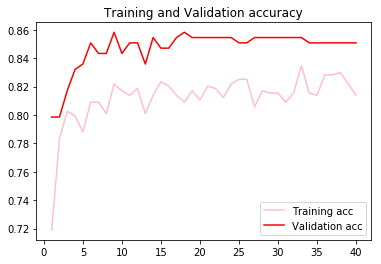

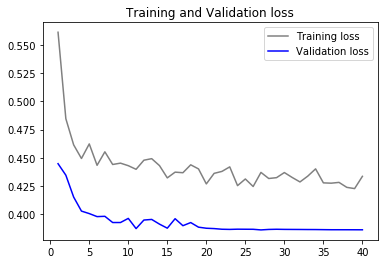

In [0]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label="Training acc", color= "pink")
plt.plot(epochs, val_acc, label="Validation acc", color= "red")
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, label="Training loss", color= "gray")
plt.plot(epochs, val_loss, label="Validation loss", color= "blue")
plt.title("Training and Validation loss")
plt.legend()

plt.show()
